In [158]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation as R
import os
import yaml
from tqdm import tqdm

class Calibrator:
    def __init__(self, config):
        self.calibration_images = []
        self.config = config
        if config['data_dir']:
            for fname in os.listdir(config['data_dir'])[:config['img_limit']]:
                img = cv.imread(config['data_dir']+'/'+fname)
                self.calibration_images.append(img)
        
        if config['include_images']:
            for fname in config['include_images']:
                img = cv.imread(config['data_dir']+'/'+fname)
                self.calibration_images.append(img)
        
        self.calib_camera_positions = []
        self.calib_corners = []
        self.online_camera_position = None
        

    def click_event(self, event, x, y, flags, params):
        if event == cv.EVENT_LBUTTONDOWN:
            # If the left mouse button is clicked, record the position
            self.corners.append((x, y))

            # Draw a circle at the position and display the coordinates
            cv.circle(self.cur_img, (x, y), self.config['circle_size'], (0, 255, 0), -1)
            cv.imshow('image', self.cur_img)
    

    def get_corners(self, img):
        self.corners = []
        self.cur_img = img
        # Create a window and set the callback function
        cv.imshow('image', img)
        cv.setMouseCallback('image', self.click_event)

        # Wait for the user to click on four corners
        while len(self.corners) < 4:
            if cv.waitKey(1) & 0xFF == ord('q'):
                break

        # Close the window
        cv.destroyAllWindows()

        # Return the corners
        return self.corners
    

    def linear_interpolation(self, corners):
        # corners must be ordered [top-left, top-right, bottom-right, bottom-left]!

        tl, tr, br, bl = [np.array(x) for x in corners]

        # Number of inner corners
        nx, ny = self.config['grid']

        # Prepare an array to hold the interpolated inner corner positions
        interpolated_corners = np.zeros((ny * nx, 2), dtype=np.float32)

        for y in range(ny):
            for x in range(nx):
                # Calculate the interpolation weights
                fx = x / (nx - 1)
                fy = y / (ny - 1)

                # Interpolate along the top and bottom edges
                top_edge = tl + (tr - tl) * fx
                bottom_edge = bl + (br - bl) * fx

                # Interpolate between the top and bottom edges to get the final position
                interpolated_point = top_edge + (bottom_edge - top_edge) * fy

                # Assign the interpolated point to the array
                interpolated_corners[y * nx + x] = interpolated_point

        return interpolated_corners
    

    def perspective_interpolation(self, corners):
        # corners must be ordered [top-left, top-right, bottom-right, bottom-left]!

        # Define the dimensions of the rectified chessboard image
        scale_factor = self.config['scale_factor']
        # Adjust width and height to account for the "extension" by one square on each side since we ask user to clicks inner corners of the outermost squares
        width = (self.config['grid'][0] + 1) * scale_factor
        height = (self.config['grid'][1] + 1) * scale_factor

        # Source points from the manually clicked outermost inner corners
        src = np.array(corners, dtype="float32")

        # Adjust destination points to "extend" the chessboard by one square in each direction
        dst = np.array([
            [scale_factor, scale_factor],  # Top-left
            [width - scale_factor - 1, scale_factor],  # Top-right
            [width - scale_factor - 1, height - scale_factor - 1],  # Bottom-right
            [scale_factor, height - scale_factor - 1]],  # Bottom-left
            dtype="float32")

        # Calculate the perspective transform matrix
        M = cv.getPerspectiveTransform(src, dst)

        # Interpolate the positions of all inner corners in the rectified image
        interpolated_corners = []
        for y in range(1, self.config['grid'][1] + 1):
            for x in range(1, self.config['grid'][0] + 1):
                point = (x * scale_factor, y * scale_factor)
                interpolated_corners.append(point)

        # Map these points back to the original image's perspective
        M_inv = cv.invert(M)[1]  # Inverse of the transformation matrix
        interpolated_corners = np.array(interpolated_corners, dtype="float32").reshape(-1, 1, 2)
        original_perspective_points = cv.perspectiveTransform(interpolated_corners, M_inv)

        # Convert points back to the original shape
        original_perspective_points = original_perspective_points.reshape(-1, 2)
        return original_perspective_points
    

    def find_contour_corners(self, contour, angle_threshold=110):
        corners = []
        for i in range(len(contour)):
            # Consider current point, previous point, and next point
            prev_point = contour[i - 1][0]
            curr_point = contour[i][0]
            next_point = contour[(i + 1) % len(contour)][0]

            # Calculate vectors
            vec_prev = prev_point - curr_point
            vec_next = next_point - curr_point

            # Normalize vectors
            vec_prev_norm = vec_prev / np.linalg.norm(vec_prev)
            vec_next_norm = vec_next / np.linalg.norm(vec_next)

            # Calculate angle between vectors (in degrees)
            angle = np.arccos(np.clip(np.dot(vec_prev_norm, vec_next_norm), -1.0, 1.0))
            angle_deg = np.degrees(angle)

            # Check if angle is sharp enough to be considered a corner
            if angle_deg < angle_threshold:
                corners.append(curr_point)

        return corners


    def refine_manual_corners(self, gray, clicked_corners):
        refined_corners = []
        localisation_window = self.config['manual_corners_window']
        criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        clicked_corners = np.array(clicked_corners, dtype=np.float32).reshape(-1, 1, 2)

        clicked_corners = cv.cornerSubPix(gray, clicked_corners, (5, 5), (-1, -1), criteria).reshape(-1, 2)
        clicked_corners = [(x[0], x[1]) for x in clicked_corners]

        # Apply dilation to the grayscale image to make the corners more prominent
        kernel = np.ones((3, 3), np.uint8)
        gray = cv.dilate(gray, kernel, iterations=1)

        for i, corner in enumerate(clicked_corners):
            # first check if a small surrounding area contains approximately uniform color, if so continue refinement for this corner
            eps_window = (5, 5)
            x_min = int(max(corner[0] - eps_window[0], 0))
            x_max = int(min(corner[0] + eps_window[0], gray.shape[1]))
            y_min = int(max(corner[1] - eps_window[1], 0))
            y_max = int(min(corner[1] + eps_window[1], gray.shape[0]))
            click_area = gray[y_min:y_max, x_min:x_max]
            # if user clicked close enough to inner corner skip refinement
            if np.std(click_area) > self.config['color_uniformity_threshold']:
                if self.config['verbose_refinement']:
                    print(f'Color uniformity not met for corner {i+1}, skipping refinement, STD : {np.std(click_area)}')
                refined_corners.append((corner[0], corner[1]))
                continue
            # Angled edges will be searched for in a local window around the clicked corner
            x_min = int(max(corner[0] - localisation_window, 0))
            x_max = int(min(corner[0] + localisation_window, gray.shape[1]))
            y_min = int(max(corner[1] - localisation_window, 0))
            y_max = int(min(corner[1] + localisation_window, gray.shape[0]))

            # Crop the region of interest (ROI) around the clicked corner
            roi = gray[y_min:y_max, x_min:x_max]

            # Apply Canny edge detector on the ROI
            edges = cv.Canny(roi, 150, 220, apertureSize=3)

            # Find contours in the ROI
            contours, _ = cv.findContours(edges, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)

            potential_corners = []
            for contour in contours:
                # Analyze contour to find corner-like features
                contour_corners = self.find_contour_corners(contour)
                potential_corners.extend(contour_corners)
            
            # Find the closest potential corner to the clicked corner (if no potential corners are found, skip refinement)
            if not potential_corners:
                if self.config['verbose_refinement']:
                    print(f'No potential corners found for corner {i+1}, skipping refinement')
                refined_corners.append((corner[0], corner[1]))
                continue
            closest_corner = min(potential_corners, key=lambda p: np.linalg.norm(p - (np.array(corner) - [x_min, y_min])))
            refined_corners.append(closest_corner + [x_min, y_min])  # Adjusting back to full image coordinates
            
        return np.array(refined_corners, dtype=np.float32)


    def calibrate(self):
        objpoints = []  # 3d point in real world space
        imgpoints = []  # 2d points in image plane.

        # Assuming square_size is known and is the same for all squares
        square_size = self.config['square_size']  # replace with your actual square size in consistent units (e.g., meters)
        objp = np.zeros((self.config['grid'][0] * self.config['grid'][1], 3), np.float32)
        objp[:,:2] = np.mgrid[0:self.config['grid'][0], 0:self.config['grid'][1]].T.reshape(-1, 2) * square_size

        print('Calibrating...')
        for img in tqdm(self.calibration_images):
            print('Processing image', img.shape)
            gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            ret, corners = cv.findChessboardCorners(gray, self.config['grid'], None)
            if ret:
                print('Chessboard Found!')
            
            if not ret:
                if not self.config['manual_corners_calibration']:
                    print('Chessboard Not found, skipping image')
                    continue
                print('Chessboard Not found, select corners maunally:')
                outer_corners = self.get_corners(img)
                if self.config['refine_manual_corners']:
                    outer_corners = self.refine_manual_corners(gray, outer_corners)
                if self.config['interpolation'] == 'perspective':
                    corners = self.perspective_interpolation(outer_corners)
                elif self.config['interpolation'] == 'linear':
                    corners = self.linear_interpolation(outer_corners)
            
            criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.01)
            if self.config['cornerSubpix_offline']:
                corners_subpix = cv.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
            else:
                corners_subpix = corners
            objpoints.append(objp)
            imgpoints.append(corners_subpix)

            if self.config['display_calibration_cameras']:
                self.calib_corners.append(corners_subpix)

            if self.config['display_calibration']:
                # Draw and display the corners
                cv.drawChessboardCorners(img, self.config['grid'], corners_subpix, ret)
                cv.imshow('Image', img)
                if self.config['display_timer']:
                    cv.waitKey(self.config['display_timer'])
                else:
                    while True:
                        if cv.waitKey(1) & 0xFF == 13:
                            break
                cv.destroyAllWindows()
        
        self.ret, self.mtx, self.dist, self.rvecs, self.tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        self.objp = objp
        K = self.mtx
        print("Intrinsic Camera Matrix (K):\n", K)
        print(f"Extrinsics Camera params: \n rvecs = {self.rvecs} :\n tvecs = {self.tvecs}")
        
        # if we want to reconstruct 3D scene with camera positions extract rvec and tvec for each calibration image
        if self.config['display_calibration_cameras']:
            for corners in self.calib_corners:
                ret, rvec, tvec = cv.solvePnP(objp, corners, self.mtx, self.dist)
                self.calib_camera_positions.append((rvec, tvec))


    def online_phase(self, img):
        # take a new image and draw the world 3D axes (XYZ) with the origin at the center of the world coordinates, using the estimated camera parameters
        #axis = np.float32([[3,0,0], [0,3,0], [0,0,-3]]).reshape(-1,3)
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        ret, corners = cv.findChessboardCorners(gray, self.config['grid'], None)
        if ret:
            print('Chessboard Found!')
        if not ret:
            print('Chessboard Not found, select corners maunally:')
            outer_corners = self.get_corners(img)
            if self.config['refine_manual_corners']:
                outer_corners = self.refine_manual_corners(gray, outer_corners)
            if self.config['interpolation'] == 'perspective':
                corners = self.perspective_interpolation(outer_corners)
            elif self.config['interpolation'] == 'linear':
                corners = self.linear_interpolation(outer_corners)
        criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.01)
        if self.config['cornerSubpix_online']:
            corners_subpix = cv.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        else:
            corners_subpix = corners
        cv.drawChessboardCorners(img, self.config['grid'], corners_subpix, True)

        ret, rvec, tvec = cv.solvePnP(self.objp, corners_subpix, self.mtx, self.dist)
        if self.config['display_online_position']:
            self.online_camera_position = (rvec, tvec)
        
        if self.config['draw_cube']:
            cube_objpoints = np.array([
                [0, 0, 0],
                [1, 0, 0],
                [1, 1, 0],
                [0, 1, 0],
                [0, 0, -1],
                [1, 0, -1],
                [1, 1, -1],
                [0, 1, -1]
            ], dtype=np.float32)*self.config['square_size']
            cube_imgpoints = cv.projectPoints(cube_objpoints, rvec, tvec, self.mtx, self.dist)[0]
            cube_imgpoints = np.int32([p.ravel() for p in cube_imgpoints])

            # Draw bottom face
            for i, j in zip(range(4), range(1, 5)):
                cv.line(img, tuple(cube_imgpoints[i]), tuple(cube_imgpoints[j % 4]), (0, 255, 0), 3)

            # Draw top face
            for i, j in zip(range(4, 8), range(5, 9)):
                cv.line(img, tuple(cube_imgpoints[i]), tuple(cube_imgpoints[j % 4 + 4]), (0, 255, 0), 3)

            # Draw sides
            for i, j in zip(range(4), range(4, 8)):
                cv.line(img, tuple(cube_imgpoints[i]), tuple(cube_imgpoints[j]), (0, 255, 0), 3)

        if self.config['draw_axes']:
            # Define the 3D points for the axes (length of 3 units in this example)
            axis = np.float32([[3, 0, 0], [0, 3, 0], [0, 0, -3]]).reshape(-1, 3)*self.config['square_size']

            # Project the 3D points to the image plane
            axis_imgpoints, _ = cv.projectPoints(axis, rvec, tvec, self.mtx, self.dist)

            # Project the origin to the image plane
            origin_imgpoint, _ = cv.projectPoints(np.float32([0, 0, 0]).reshape(-1, 3), rvec, tvec, self.mtx, self.dist)

            # Draw the axes lines: origin to each of the projected axis points
            colors = [(0, 0, 255), (0, 255, 0), (255, 0, 0)]  # BGR colors for X, Y, Z axes
            for i, color in enumerate(colors):
                # Ensure the points are integer tuples
                pt1 = tuple(np.int32(origin_imgpoint[0].ravel()))
                pt2 = tuple(np.int32(axis_imgpoints[i].ravel()))
                cv.line(img, pt1, pt2, color, 3)
            
            label_offset = 5.0  # Adjust the offset as needed
            axis_labels = np.float32([[3*self.config['square_size']+label_offset, 0, 0], [0, 3*self.config['square_size']+label_offset, 0], [0, 0, -3*self.config['square_size']-label_offset]]).reshape(-1, 3)

            # Project the 3D points for the labels to the image plane
            label_imgpoints, _ = cv.projectPoints(axis_labels, rvec, tvec, self.mtx, self.dist)

            # Labels for each axis
            labels = ['X', 'Y', 'Z']

            # Draw the labels next to the axes
            for i, label in enumerate(labels):
                # Ensure the label points are integer tuples
                label_point = tuple(np.int32(label_imgpoints[i].ravel()))

                # Put the label text on the image
                cv.putText(img, label, label_point, cv.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 255), 1)

        # Show the image
        cv.imshow('Cube Image', img)
        while True:
            if cv.waitKey(1) & 0xFF == 13:
                break
        cv.destroyAllWindows()
        return rvec, tvec


    def test_interpolation(self, img):
        #function to test the interpolation method separately
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        outer_corners = self.get_corners(img)
        if self.config['refine_manual_corners']:
            outer_corners = self.refine_manual_corners(gray, outer_corners)
        criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.01)
        if self.config['interpolation'] == 'perspective':
            corners = self.perspective_interpolation(outer_corners)
        elif self.config['interpolation'] == 'linear':
            corners = self.linear_interpolation(outer_corners)
        corners_subpix = cv.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        cv.drawChessboardCorners(img, self.config['grid'], corners_subpix, True)
        cv.imshow('Image', img)
        while True:
            if cv.waitKey(1) & 0xFF == 13:
                break
        cv.destroyAllWindows()
    

    def compare_interpolation(self, img):
        #function to test the interpolation method separately
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        outer_corners = self.get_corners(img)
        criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.01)
        corners_pp = self.perspective_interpolation(outer_corners)
        corners_subpix_pp = cv.cornerSubPix(gray, corners_pp, (11, 11), (-1, -1), criteria)
        img1 = img.copy()
        img2 = img.copy()
        cv.drawChessboardCorners(img1, self.config['grid'], corners_subpix_pp, True)
        cv.imshow('perspective interpolation', img1)

        corners_lin = self.linear_interpolation(outer_corners)
        corners_subpix_lin = cv.cornerSubPix(gray, corners_lin, (11, 11), (-1, -1), criteria)
        cv.drawChessboardCorners(img2, self.config['grid'], corners_subpix_lin, True)
        cv.imshow('linear interpolation', img2)
        while True:
            if cv.waitKey(1) & 0xFF == 13:
                break
        cv.destroyAllWindows()
    

    def test_corner_refinement(self, img):
        # test corner refinement method separately and show the difference between refined and unrefined corners
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        outer_corners = self.get_corners(img)
        if self.config['interpolation'] == 'perspective':
            unrefined_corners = self.perspective_interpolation(outer_corners)
        elif self.config['interpolation'] == 'linear':
            unrefined_corners = self.linear_interpolation(outer_corners)
        criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.01)
        unrefined_corners_subpix = cv.cornerSubPix(gray, unrefined_corners, (11, 11), (-1, -1), criteria)
        img_unrefined = img.copy()
        cv.drawChessboardCorners(img_unrefined, self.config['grid'], unrefined_corners_subpix, True)
        cv.imshow('No manual corners refinement', img_unrefined)
        # press Enter to continue
        while True:
            if cv.waitKey(1) & 0xFF == 13:
                break
        cv.destroyAllWindows()

        refined_corners = self.refine_manual_corners(gray, outer_corners)
        # Draw the refined corners
        for corner in refined_corners:
            corner = tuple(np.int32(corner))
            cv.circle(img, corner, 5, (255, 0, 0), -1)
            cv.imshow('Refined corners adjustment', img)
        # press Enter to continue
        while True:
            if cv.waitKey(1) & 0xFF == 13:
                break
        cv.destroyAllWindows()
        if self.config['interpolation'] == 'perspective':
            refined_corners = self.perspective_interpolation(refined_corners)
        elif self.config['interpolation'] == 'linear':
            refined_corners = self.linear_interpolation(refined_corners)
        refined_corners_subpix = cv.cornerSubPix(gray, refined_corners, (11, 11), (-1, -1), criteria)
        img_refined = img.copy()
        cv.drawChessboardCorners(img_refined, self.config['grid'], refined_corners_subpix, True)
        cv.imshow('With manual corners refinement', img_refined)
        # press Enter to continue
        while True:
            if cv.waitKey(1) & 0xFF == 13:
                break
        cv.destroyAllWindows()


    # display camera positions is not fully functional yet 
    def rvec_to_rotation_matrix(self, rvec):
        R, _ = cv.Rodrigues(rvec)
        return R


    def display_camera_positions(self):
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')

        # Plot chessboard
        for point in self.objp:
            ax.scatter(point[0], point[1], point[2], color='black')


    # Function to draw cameras
    def draw_camera(self, position, orientation, ax, camera_label, color='red'):
        camera_pos = position.T[0]
        if camera_label == 'Online Cam':
            print('Online Camera Position:', camera_pos)

        # adjust x y z based on config bias parameters X_adj, Y_adj, Z_adj
        ax.scatter(camera_pos[0], camera_pos[1], camera_pos[2], color=color, s=100, label=camera_label)
        
        # Assuming the camera's Z-axis points into the scene, calculate the direction vector
        direction_vector = np.dot(orientation, np.array([0, 0, 1]).T)  # Original direction vector
        
        # Invert the Z component to mirror the vector with respect to the XY plane
        direction_vector[2] = -direction_vector[2]  # Inverts the Z component
        direction_point = camera_pos + 7 * direction_vector  # Scale for visibility
        
        # Draw line indicating camera direction
        ax.plot([camera_pos[0], direction_point[0]], [camera_pos[1], direction_point[1]], [camera_pos[2], direction_point[2]], color='blue')
        
        # Draw each calibration camera
        if self.config['display_calibration_cameras']:
            for idx, (rvec, tvec) in enumerate(self.calib_camera_positions):
                R = self.rvec_to_rotation_matrix(rvec)
                self.draw_camera(tvec, R, ax, f'Calib Cam {idx+1}')

        # Draw online camera if exists
        if self.config['display_online_position']:
            rvec, tvec = self.online_camera_position
            R = self.rvec_to_rotation_matrix(rvec)
            self.draw_camera(tvec, R, ax, 'Online Cam', color='blue')

            ax.set_xlim(-30, 30)
            ax.set_ylim(-30, 30)

            ax.legend()
            plt.show()


    def save_camera_params(self, calibrator, rvec, tvec, path):
        cv_file = cv.FileStorage(path+'calibration_params.xml', cv.FILE_STORAGE_WRITE)
        cv_file.write("CameraMatrix", calibrator.mtx)
        cv_file.write("DistortionCoeffs", calibrator.dist)
        cv_file.write("Rvec", rvec)
        cv_file.write("Tvec", tvec)


    def extract_camera_params(self, config, path, cam_name, num_calibrations=50):
        cap = cv.VideoCapture(path+cam_name+"/intrinsics.avi")
        calibration_frames = []
        for i in range(num_calibrations):
            frame_id = np.random.randint(0, int(cap.get(cv.CAP_PROP_FRAME_COUNT)))
            cap.set(cv.CAP_PROP_POS_FRAMES, frame_id)
            ret, frame = cap.read()
            if ret:
                calibration_frames.append(frame)

        calibrator = Calibrator(config)

        calibrator.calibration_images = calibration_frames
        calibrator.calibrate()

        n = 1
        cap = cv.VideoCapture(path+cam_name+"/checkerboard.avi")
        online_frames = []
        for i in range(n):
            frame_id = np.random.randint(0, int(cap.get(cv.CAP_PROP_FRAME_COUNT)))
            cap.set(cv.CAP_PROP_POS_FRAMES, frame_id)
            ret, frame = cap.read()
            online_frames.append(frame)

        calibrator.config['refine_manual_corners'] = False
        rvec, tvec = calibrator.online_phase(online_frames[0])

        self.save_camera_params(calibrator, rvec, tvec, f'data/{cam_name}/')

        return calibrator, rvec, tvec


    def calibration(self):
        with open("calibrator_config.yaml") as f:
            calib_config = yaml.load(f, Loader=yaml.FullLoader)
            calibrator, rvec, tvec = self.extract_camera_params(calib_config, 'data/', 'cam1')
            calibrator, rvec, tvec = self.extract_camera_params(calib_config, 'data/', 'cam2')
            calibrator, rvec, tvec = self.extract_camera_params(calib_config, 'data/', 'cam3')
            calibrator, rvec, tvec = self.extract_camera_params(calib_config, 'data/', 'cam4')


    def generate_background_models(self):
        cameras = ['cam1', 'cam2', 'cam3', 'cam4']
        background_models = []

        for cam_name in cameras:
            cap = cv.VideoCapture('data/'+cam_name+"/background.avi")
            total_frames = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
            frame_count = 0
            
            bg_subtractor = cv.bgsegm.createBackgroundSubtractorMOG()

            while frame_count < total_frames:  
                    ret, frame = cap.read()
                    
                    if ret:
                        fg_mask = bg_subtractor.apply(frame)

                    frame_count +=1
                    
            cap.release()
            background_models.append(bg_subtractor)
            
        return background_models

    # online phase: use the model to extract from one frame
    # avoid pre-processing and post-processing by  usign findContours to focus on the main object 
    def extract_foreground(self, background_models):
        cameras = ['cam1', 'cam2', 'cam3', 'cam4']
        foregrounds = []
        fg_objs = []
        num_frames_subtraction = 1

        for cam_name in cameras:
            cap = cv.VideoCapture('data/'+cam_name+"/video.avi")
            total_frames = int(cap.get(cv.CAP_PROP_FRAME_COUNT))

            for frame_idx in range(num_frames_subtraction):
                frame_id = np.random.randint(0, total_frames)
                cap.set(cv.CAP_PROP_POS_FRAMES, frame_id)  

                ret, frame = cap.read()
                
                if ret:
                    # extract foreground by doing the online phase with the background model
                    foreground = background_models[cameras.index(cam_name)].apply(frame)
                    cv.imshow("Foreground", foreground)
                    cv.waitKey(2000)
                    

                    # find and draw the contours of the largest object
                    contours, _ = cv.findContours(foreground, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
                    largest_contour = max(contours, key=cv.contourArea)
                    contour_image =  cv.cvtColor(np.zeros_like(frame), cv.COLOR_BGR2GRAY)
                    cv.drawContours(contour_image, [largest_contour], -1, (255), thickness=cv.FILLED)
                    cv.imshow("Contours", contour_image)
                    cv.waitKey(2000)

                    # subtracting the irrelevant foreground
                    fg_obj = cv.bitwise_and(contour_image, foreground)
                    cv.imshow("Extract Object from foreground", fg_obj)
                    cv.waitKey(2000)
                    cv.destroyAllWindows()
                    
                    foregrounds.append(foreground)
                    fg_objs.append(fg_obj)
                    
            cap.release()
            cv.destroyAllWindows()
        
        return foregrounds, fg_objs


    def reduce_noise(self, fg_objs):
        morph_ops = []
        processed = []
        params = cv.SimpleBlobDetector_Params()
        params.filterByArea = True
        params.filterByColor = True
        params.blobColor = 0  
        num_iter = 4

        for curr_iter in range(num_iter):
    
            if curr_iter == 0:
                processed = fg_objs
                params.minArea = 60
                detector = cv.SimpleBlobDetector_create(params)
                kernel_size = 7
                kernel = np.ones((kernel_size, kernel_size), np.uint8)
            else:
                processed = morph_ops.copy()
                morph_ops.clear()
                kerle_size = kernel_size-2
                kernel = np.ones((kernel_size, kernel_size), np.uint8)
                params.minArea = params.minArea // 3
                detector = cv.SimpleBlobDetector_create(params)
                

            for image in processed:
                # Closing
                close = cv.morphologyEx(image, cv.MORPH_CLOSE, kernel)

                # Use blob detection to fill holes in the closed foreground object
                keypoints = detector.detect(close)
                if keypoints:
                    filled_contour_image = np.zeros_like(image)
                    
                    for keypoint in keypoints:
                        cv.circle(filled_contour_image, (int(keypoint.pt[0]), int(keypoint.pt[1])), int(keypoint.size / 2), (255), thickness=cv.FILLED)
                    
                    filled_contour_image =  cv.bitwise_or(filled_contour_image, close)
                    
                    #store result
                    morph_ops.append(filled_contour_image)
                    
                # Otherwise just apply closing to the preprocessed image
                else:
                    morph_ops.append(close)
                
        return morph_ops
    

    def show_differences(self, fg, fg_objs, denoised):
        titles = ['Foreground', 'Foreground object', 'Denoised and filled']
        cameras = ['cam1', 'cam2', 'cam3', 'cam4']
        fig, axs = plt.subplots(len(cameras), 3, figsize=(8, 8))

        for cam_idx in range(len(cameras)):
            axs[cam_idx, 0].imshow(fg[cam_idx], cmap='gray')
            axs[cam_idx, 0].set_title(f'{titles[0]} - {cameras[cam_idx]}')
            axs[cam_idx, 0].set_xticks([])
            axs[cam_idx, 0].set_yticks([])

            axs[cam_idx, 1].imshow(fg_objs[cam_idx], cmap='gray')
            axs[cam_idx, 1].set_title(f'{titles[1]} - {cameras[cam_idx]}')
            axs[cam_idx, 1].set_xticks([])
            axs[cam_idx, 1].set_yticks([])

            axs[cam_idx, 2].imshow(denoised[cam_idx], cmap='gray')
            axs[cam_idx, 2].set_title(f'{titles[2]} - {cameras[cam_idx]}')
            axs[cam_idx, 2].set_xticks([])
            axs[cam_idx, 2].set_yticks([])

        plt.tight_layout()  
        plt.show()


    def subtract_background(self):
        background_models = self.generate_background_models() # generating backgrounds with GMM
        foregrounds, fg_objs = self.extract_foreground(background_models) # subtracting backgorund: contours detection, bitwise and
        denoised = self.reduce_noise(fg_objs) #  morphological ops on silhouettes (erosion, dilation) and filling the holes (blob detection)
        self.show_differences(foregrounds, fg_objs, denoised)




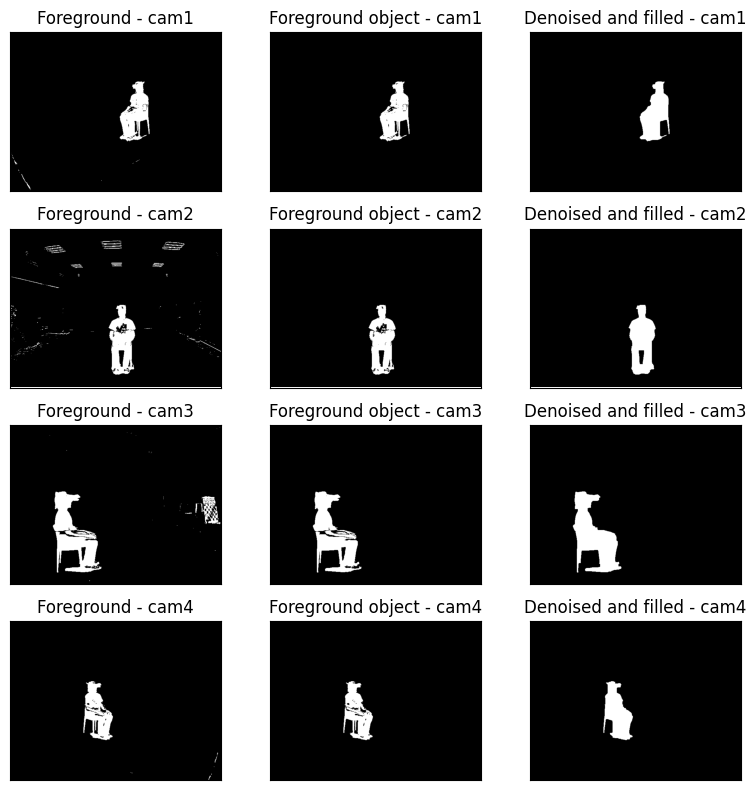

In [159]:
if __name__ == '__main__':
    with open("calibrator_config.yaml") as f:
        calib_config = yaml.load(f, Loader=yaml.FullLoader)
        calibrator = Calibrator(calib_config)
        #calibrator.subtract_background()
        calibrator.subtract_background()

